## This notebook consists of using Unet to detect and segment organs frm the University of Wisconsin Madison dataset from kaggle. 
## Link to dataset https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/data


In [2]:
import numpy as np
import pandas as pd
import torch
import torchvision
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image, ImageOps
import os
import matplotlib.colors
import cv2
from skimage.transform import rescale, resize
import re
import torchmetrics
import torchvision.transforms.v2 as transforms
from torchvision import tv_tensors
import matplotlib.colors as colors
from torchmetrics.segmentation import HausdorffDistance
import os
from tqdm.notebook import tqdm
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

## The data consists of the train data file of the images and the corresponding csv consisting of the patients ids and the binary msks of the large bowel, small bowel and the stomach as rle masks.

In [3]:
df = pd.read_csv('/kaggle/input/uw-madison-gi-tract-image-segmentation/train.csv')
df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [4]:
new_df = df.replace(np.nan, 0)
new_df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,0
1,case123_day20_slice_0001,small_bowel,0
2,case123_day20_slice_0001,stomach,0
3,case123_day20_slice_0002,large_bowel,0
4,case123_day20_slice_0002,small_bowel,0


### Function to convert rle to binary masks to be used later when creating the dataset

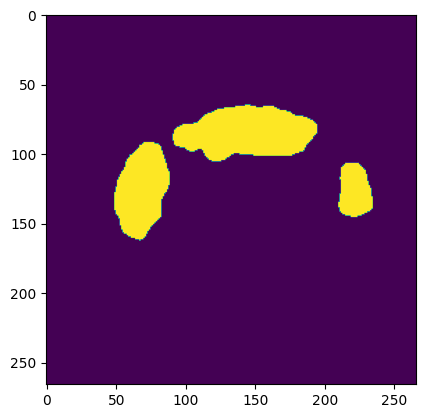

In [5]:
def rle2binary(rle_str, img):
    mask = np.zeros(img.shape[0]**2)
    rle = np.array([eval(i) for i in rle_str.split(' ')])
    index, pixels = rle[::2], rle[1::2]
    if rle_str != '0':
        for i, ind in enumerate(index):
            mask[ind:ind+pixels[i]]=1
    return mask.reshape(img.shape)
mask =rle2binary(new_df.segmentation[115446], np.zeros((266,266)))
plt.imshow(mask)

### csv file clean up and processing

In [24]:
id = []
stomach = []
small_bowel = []
large_bowel =[]
i=0
while i < len(new_df)-2:
    id.append(new_df.loc[i, 'id'])
    large_bowel.append(new_df.loc[i, 'segmentation'])
    small_bowel.append(new_df.loc[i+1, 'segmentation'])
    stomach.append(new_df.loc[i+2, 'segmentation'])
    i+=3
final_df = pd.DataFrame({'id':id, 'large_bowel':large_bowel, 'small_bowel':small_bowel, 'stomach': stomach})
# final_df = final_df.sample(len(final_df),random_state=101)
final_df
submission_df = final_df

In [7]:
final_df[final_df['large_bowel']!=0]

,id,large_bowel,small_bowel,stomach
74,case123_day20_slice_0075,23058 4 23323 6 23588 8 23854 9 24119 10 24385...,0,12388 11 12652 14 12916 18 13180 22 13445 24 1...
75,case123_day20_slice_0076,22525 6 22789 9 23055 10 23320 11 23586 11 238...,0,12120 12 12384 16 12648 19 12913 22 13177 25 1...
76,case123_day20_slice_0077,19337 6 19602 8 19867 9 20133 9 20398 10 20664...,0,11852 13 12117 16 12382 18 12646 22 12911 24 1...
77,case123_day20_slice_0078,18541 4 18805 8 19070 10 19335 11 19600 13 198...,0,11589 3 11849 17 12114 19 12379 22 12643 25 12...
78,case123_day20_slice_0079,18275 6 18539 9 18804 11 19069 13 19334 14 195...,0,11583 14 11847 19 12112 22 12377 24 12642 26 1...
...,...,...,...,...
38484,case30_day0_slice_0133,17695 8 17957 23 18213 39 18477 45 18741 52 19...,23337 15 23601 20 23866 23 24131 25 24396 27 2...,0
38485,case30_day0_slice_0134,17694 5 17957 10 18215 2 18219 17 18478 32 187...,23336 13 23601 16 23867 18 24132 20 24398 21 2...,0
38486,case30_day0_slice_0135,17957 1 18219 10 18482 16 18744 23 19008 43 19...,22540 1 22804 5 23069 7 23334 10 23600 11 2386...,0
38487,case30_day0_slice_0136,18746 7 19009 23 19038 7 19273 44 19537 49 198...,23079 1 23343 6 23608 9 23874 11 24139 13 2440...,0


### Shuffling the .csv file. Gave better results probably due to data distribution variation when splitting into test and train data

In [8]:
final_df = final_df.sample(len(final_df),random_state=101)
final_df[final_df['large_bowel']!=0]

,id,large_bowel,small_bowel,stomach
30425,case18_day19_slice_0074,34006 11 34361 18 34718 24 35074 31 35433 34 3...,0,42698 5 43056 10 43415 13 43728 12 43774 14 44...
37005,case2_day5_slice_0094,23761 4 24018 15 24282 17 24547 19 24811 21 25...,19804 5 20068 8 20332 12 20596 14 20862 15 211...,0
11015,case134_day0_slice_0104,51929 4 52286 11 52645 17 53004 21 53363 23 53...,41974 16 42325 34 42682 40 43034 52 43390 59 4...,0
14174,case6_day0_slice_0095,19643 6 20001 11 20360 13 20719 16 21079 17 21...,23925 4 24283 7 24643 9 25002 11 25362 13 2572...,0
18059,case119_day0_slice_0092,21114 6 21472 11 21831 14 22190 16 22550 18 22...,37984 6 38342 10 38701 13 39061 14 39420 17 39...,0
...,...,...,...,...
32817,case54_day0_slice_0082,20603 8 20867 13 21132 16 21398 18 21663 21 21...,22235 11 22500 14 22765 16 23031 17 23297 18 2...,0
13020,case49_day0_slice_0093,44150 5 44507 14 44866 17 45225 21 45585 24 45...,35444 42 35801 47 36158 52 36478 12 36517 56 3...,0
22056,case111_day0_slice_0057,27316 10 27581 13 27846 15 28112 16 28377 18 2...,0,26230 8 26493 13 26757 17 27021 20 27286 22 27...
17357,case101_day22_slice_0110,30537 8 30801 13 31066 15 31331 17 31596 19 31...,22213 8 22229 18 22478 11 22492 25 22743 44 23...,0


### Dataset creation.
* __getitem__ of the dataset class accesses the index, normalizes and standarizes it
* Resize the image to 224, 224 after converting rle to masks
* Augment the image an masks with applied augmentation if given

In [9]:
class GI_Tract_Dataset(torch.utils.data.Dataset):
    """
    Dataset class to create image dataset
    @param root --  Root folder of the images
    @param csv  --  csv file containing the rle masks and patient ids
    @param transform -- Transformations to be applied to image and mask. Must be of class torchvision.transforms.v2
    @param get_id  -- Get the case_id. Default False. If set to True returns case_id as the first parameter
    @returns -- torch tenor of image and mask. If get_id = True then returns id, image, mask
    
    """
    def __init__(self, root, csv_file, transform =None, get_id = False):
        super().__init__()
        self.filenames = self.extract_files(root)
        self.csv_file = csv_file
        self.transform= transform
        self.get_id = get_id

    @staticmethod
    def extract_files(root):

        file_paths = []
        for folder, files, filenames in os.walk(root):
            for file in filenames:
                if file.endswith('.png'):
                    file_paths.append((os.path.join(folder, file)))
        return file_paths

    @staticmethod
    def rle2binary(*rle_string, img_size):

        mask = np.stack((np.zeros(img_size[0]*img_size[1]),np.zeros(img_size[0]*img_size[1]),np.zeros(img_size[0]*img_size[1])))
        channel = 0
        for rle_str in rle_string:
            if rle_str!=0:
                rle = np.array([eval(i) for i in rle_str.split(' ')])
                index, pixels = rle[::2], rle[1::2]
                for i, ind in enumerate(index):
                    mask[channel][ind:ind+pixels[i]]=1
            channel+=1
        return mask.reshape(3,img_size[0], img_size[1])

    @staticmethod
    def normalize_standardize(img):

        normalized_img = (img - np.mean(img))/np.std(img)
        standardized_image = (normalized_img - normalized_img.min())/(normalized_img.max() - normalized_img.min())
        return standardized_image

    def augment(self, img, masks):
        seed = torch.randint(0, 10000,(1,)).item()
        torch.manual_seed(seed)
        # imgaug.seed(seed)
        torch.random.manual_seed(seed)
        masks = tv_tensors.Mask(masks)
        img = tv_tensors.Image(img)
        img, masks = self.transform(img, masks)
        return img, masks

        return img,masks

    def __len__(self):

        return len(self.csv_file)

    def __getitem__(self, index):

        file = self.csv_file.iloc[index]['id']
        case_id_file, size = self.get_file_size(file)

        img = Image.open(case_id_file)
        img = np.array([img.getdata()]).reshape(size)
        img = (img - img.min())/(img.max()- img.min())

        rle_masks = self.csv_file.iloc[index][['large_bowel', 'small_bowel', 'stomach']].values
        labels = self.rle2binary(*rle_masks, img_size=size)
        img = self.normalize_standardize(img)
        img = resize(img, (224,224))
        img = np.expand_dims(img,axis = 0)
        masks = resize(labels,(3,224,224), order = 0)


        if self.transform:
            img, masks = self.augment(img, masks)
            
        if self.get_id ==True:
            return file, torch.tensor(img),torch.tensor(masks).int().float()
            
        else:
            return torch.tensor(img),torch.tensor(masks).int().float()

    # @staticmethod
    def get_file_size(self,id_name):

        part_path = id_name.split('_slice')[0]+'/scans/slice_'+id_name.split('_slice_')[-1]
        size = None
        for file in self.filenames:
            if part_path in file:
                size = re.search('_\\d{3}_\\d{3}_' ,file).group(0).split('_')[1:3]
                size = (eval(size[0]), eval(size[1]))
                return file, size
        if size ==None:
            raise Exception(f'File {part_path} not found')


### Test dataset creation and plot

torch.Size([1, 224, 224]) torch.Size([3, 224, 224])


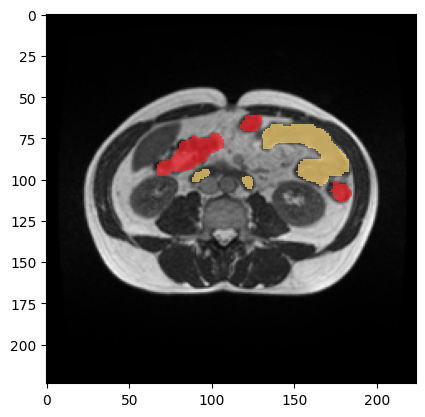

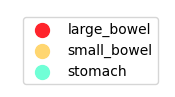

In [10]:
ds = GI_Tract_Dataset('/kaggle/input/uw-madison-gi-tract-image-segmentation/train', final_df)
img, label = ds[32000]
print(img.shape, label.shape)

cmaps = ['viridis', 'turbo', 'twilight']
classes = ['large_bowel', 'small_bowel', 'stomach']
c =['#ff242c', '#ffd670', '#70ffd6']
plt.imshow(img[0], cmap = 'gray')
for k in range(3):
    mask = label[k]
    mask_ = np.ma.masked_where(mask == 0, mask)
    cmaps= colors.ListedColormap(c[k])
    plt.imshow(mask_, cmap = cmaps, alpha = 0.7,label = classes[k])

plt.figure(figsize=(2, 1))     #View colorbar and class names
plt.scatter([], [], c='#ff242c', label='large_bowel', s=100)
plt.scatter([], [], c='#ffd670', label='small_bowel', s=100)
plt.scatter([], [], c='#70ffd6', label='stomach', s=100)
plt.axis(False)
plt.legend()
plt.show()


### Get class label weights to be passed on the the weighted random sampler for the train loader to make sure that there is no imbalance in the batches while training.

In [11]:
mask_slices = []
for i in tqdm(range(int(len(final_df)*0.9))):
    slice_info = final_df.iloc[i]
    if slice_info['large_bowel'] == 0 and slice_info['small_bowel'] == 0 and slice_info['stomach'] == 0:
        mask_slices.append(0)
    elif slice_info['large_bowel'] == 0 and slice_info['small_bowel'] != 0 and slice_info['stomach'] != 0:
        mask_slices.append(1)
    elif slice_info['large_bowel'] != 0 and slice_info['small_bowel'] == 0 and slice_info['stomach'] != 0:
        mask_slices.append(1)
    elif slice_info['large_bowel'] != 0 and slice_info['small_bowel'] != 0 and slice_info['stomach'] == 0:
        mask_slices.append(1)
    elif slice_info['large_bowel'] == 0 and slice_info['small_bowel'] == 0 and slice_info['stomach'] != 0:
        mask_slices.append(2)
    elif slice_info['large_bowel'] == 0 and slice_info['small_bowel'] != 0 and slice_info['stomach'] == 0:
        mask_slices.append(2)
    elif slice_info['large_bowel'] != 0 and slice_info['small_bowel'] == 0 and slice_info['stomach'] == 0:
        mask_slices.append(2)
    elif slice_info['large_bowel'] != 0 and slice_info['small_bowel'] != 0 and slice_info['stomach'] != 0:
        mask_slices.append(3)
    else:
        print('No condition met')

mask_counts = np.unique(mask_slices, return_counts = True)
print(np.unique(mask_slices, return_counts = True))
weights = [len(final_df)/i for i in mask_counts[1]]
print(weights)
class_weights = [weights[i] for i in mask_slices]
print(len(class_weights))
print(np.unique(class_weights, return_counts=True))

  0%|          | 0/34646 [00:00<?, ?it/s]

(array([0, 1, 2, 3]), array([19679,  9851,  2238,  2878]))
[1.9561969612277046, 3.9078266165871485, 17.201072386058982, 13.37595552466991]
34646
(array([ 1.95619696,  3.90782662, 13.37595552, 17.20107239]), array([19679,  9851,  2878,  2238]))


## Create train and validation loaders. 
* Train loader and val loader split as 90:10 ratio.
* Random affine, horizotal flip, resizig and cropping and elastic transform appllied to the train data

In [12]:
train_transforms = transforms.Compose([transforms.RandomAffine(degrees = (-35,35), translate=(0, 0.15),scale=(0.9, 1.1)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomResizedCrop(size=(224,224), scale= (0.35,1.25)),
                                       transforms.ElasticTransform()])

train_data = GI_Tract_Dataset('/kaggle/input/uw-madison-gi-tract-image-segmentation/train', final_df[0:int(len(final_df)*0.9)], transform = train_transforms)
val_data = GI_Tract_Dataset('/kaggle/input/uw-madison-gi-tract-image-segmentation/train', final_df[int(len(final_df)*0.9):])

sampler = torch.utils.data.WeightedRandomSampler(weights = class_weights, num_samples = len(train_data))
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 8, sampler = sampler)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = 8, shuffle = False)
print(len(train_loader), len(val_loader))

4331 482


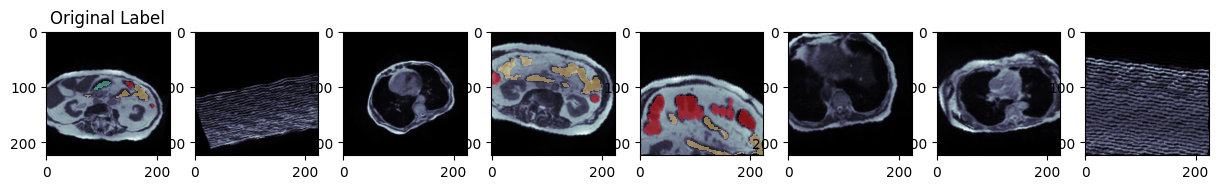

In [13]:
torch.manual_seed(42)
for b,(slices, masks) in enumerate(train_loader):
    plt.close('all')
    fig, ax = plt.subplots(1, slices.shape[0], figsize = (15,5))
    classes = ['large_bowel', 'small_bowel', 'stomach']
    c =['#ff242c', '#ffd670', '#70ffd6']
    ax[0].set_title('Original Label')
    for i in range(slices.shape[0]):
        slice, mask = slices[i], masks[i]
        ax[i].imshow(slice[0], cmap = 'bone')
        ax[i].imshow(slice[0], cmap = 'bone')

        for j in range(3):
            mask_ = np.ma.masked_where(mask[j] ==0,mask[j])
            cmaps= colors.ListedColormap(c[j])
            ax[i].imshow(mask_, alpha = 0.5, cmap = cmaps)
    break

## The standard Unet architecture is used to train the model with double convolution layers along with batch noramlization to apply regularization and avoid overfitting

In [14]:
class DoubleConv(torch.nn.Module):
    '''
    torch Module class to create double convolution layers
    @param in_channels -- Number of input channels
    @param out_channels -- Number of output channels
    @param relu -- (type bool)Add relu activation layer. 
    Applying relu to the last layer of the unet in torch can sometimes yield all zero masks according to the post below
    https://discuss.pytorch.org/t/unet-implementation/426/19?u=ptrblck
    
    @return -- torch Module double convolution layer
    '''
    def __init__(self, in_channels, out_channels, relu):
        super().__init__()
        self.relu =relu
        self.conv = torch.nn.Sequential(torch.nn.Conv2d(in_channels , out_channels, kernel_size=3, padding=1), torch.nn.BatchNorm2d(out_channels), torch.nn.ReLU(),
                                        torch.nn.Conv2d(out_channels , out_channels, kernel_size=3, padding=1), torch.nn.BatchNorm2d(out_channels),torch.nn.ReLU())
        self.skip_relu = torch.nn.Sequential(torch.nn.Conv2d(in_channels , out_channels, kernel_size=3, padding=1), torch.nn.BatchNorm2d(out_channels),
                                        torch.nn.Conv2d(out_channels , out_channels, kernel_size=3, padding=1,), torch.nn.BatchNorm2d(out_channels))

    def forward(self, X):
        if self.relu == True:
            return self.skip_relu(X)
        else:
            return self.conv(X)


class Unet(torch.nn.Module):
    '''
    torch Module class to create the Unet model
    @param in_channels -- Number of input channels
    @param out_channels -- Number of output channels
    @return -- Unet moel of class nn.Module
    '''
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder1 = DoubleConv(in_channels,64, False)
        self.encoder2 = DoubleConv(64,128, False)
        self.encoder3 = DoubleConv(128,256, False)
        self.encoder4 = DoubleConv(256,512, False)
        self.encoder5 = DoubleConv(512, 1024, False)
        self.decoder1 = DoubleConv(1024+512,512, False)
        self.decoder2 = DoubleConv(512+256, 256, False)
        self.decoder3 = DoubleConv(256+128,128, False)
        self.decoder4 = DoubleConv(128+64,64, False)
        self.out = torch.nn.Conv2d(64, out_channels, kernel_size=1)
        self.upSample = torch.nn.UpsamplingBilinear2d(scale_factor=2)
        self.MaxPool = torch.nn.MaxPool2d(kernel_size=2)

    def forward(self, X):
        x1= self.encoder1(X)
        x1_m = self.MaxPool(x1)

        x2= self.encoder2(x1_m)
        x2_m = self.MaxPool(x2)

        x3= self.encoder3(x2_m)
        x3_m = self.MaxPool(x3)

        x4= self.encoder4(x3_m)
        x4_m = self.MaxPool(x4)

        x5 = self.encoder5(x4_m)

        x6 = self.upSample(x5)
        x6 = torch.concat([x4, x6], axis = 1)
        x6 = self.decoder1(x6)
       
        x7 = self.upSample(x6)
        x7 = torch.concat([x3,x7], axis = 1)
        x7 = self.decoder2(x7)
        
        x8 = self.upSample(x7)
        x8 = torch.concat([x2,x8], axis = 1)
        x8 = self.decoder3(x8)
        
        x9 = self.upSample(x8)
        x9 = torch.concat([x1,x9], axis = 1)
        x9 = self.decoder4(x9)
        
        out = self.out(x9)
        return out     
    






## Create class for Dice Loss and Hausdorff Distance calculation

In [15]:
class DiceLoss(torch.nn.Module):
    '''
    Torch Module class to calculated the genralized Dice Loss with custom penalty
    Parameters -None
    @returns - Generalized dice loss across all the channels.
    '''
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
        '''
        @param - pred and mask of shape batch_size, channels, height, width when using the module to calculate loss
        '''
        dice_ave = 0
        for b in range(pred.shape[0]):
            for i in range(pred.shape[1]):
                pred_, mask_ = pred[b][i], mask[b][i]
                pred_ = torch.flatten(pred_)
                mask_ = torch.flatten(mask_)
                numerator = (pred_* mask_).sum()
                denominator = pred_.sum() + mask_.sum() + 1e-7
                dice = (2*numerator)/denominator
                '''
                Custom penalty if both prediction and/or label are zero snce the dice coefficiet would be 0 instead of 1.
                Add penalty of 1 if both label and mask are empty thereby dice coefficient equals 1 else find how many pixels 
                are segmented by the model that are empty. Otherwise donot add penalty
                '''        
                if torch.any(mask_) == False and torch.any(pred_>0.5)==False:
                    penalty = 1
                elif torch.any(mask_) == False and torch.any(pred_>0.5)==True:
                    penalty = 1- (torch.sum(pred_>0.5)/pred_.numel())
                else:
                    penalty = 0
                dice_ave+= dice + penalty
        dice_coeff = dice_ave / (pred.shape[0]* pred.shape[1])
        return 1-dice_coeff

class Dice_Hausdorff(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, label):
        non_empty_preds = []
        non_empty_labels = []
        hausdorff_dist = 0
        count = 0
        for b in range(pred.shape[0]):
            for i in range(pred.shape[1]):
                pred_ = pred[b][i]
                label_ = label[b][i]
                if torch.any(label_)==False:
                    pass
                else:
                    hausdorff_dist+= HausdorffDistance(num_classes=1)(pred_.unsqueeze(0).unsqueeze(0)>0.5, label_.unsqueeze(0).unsqueeze(0).bool())
                    count+=1
        if count != 0:
            hausdorff_dist/=count
        return 0.6*hausdorff_dist + 0.4*DiceLoss()(pred, label)

### Other helper functions
* label_multiclass converts labels to single channel multiclass mask for cross entropy loss claculation
* label_to_channels converts predictions to appropriate number of channels for calculating Dice Loss
* plot_results_multilabel plots the results of the original label and predicted masks

In [16]:
def label_multiclass(labels):
  labels_multiclass = torch.zeros_like(labels)
  for b in range(labels.shape[0]):
    for c in range(labels.shape[1]):
      labels_multiclass[b][c] = labels[b][c]*(c+1)

  labels_multiclass = torch.sum(labels_multiclass, dim =1)
  labels_multiclass[labels_multiclass > 3] = 0

  return labels_multiclass

def label_to_channels(prediction):
    labels = torch.zeros(prediction.shape[0],3, prediction.shape[-2], prediction.shape[-1])
    for b in range(prediction.shape[0]):
        for c in range(prediction.shape[1]-1):
            labels[b][c] = prediction[b][c+1]
            # labels[b][c][labels[b][c]>0] ==1
    return labels
    

def plot_results_multilabel(slices, masks, predictions):
    plt.close('all')
    fig, ax = plt.subplots(2, slices.shape[0]+1, figsize =(15,5))
    masks = label_multiclass(masks)
    classes = {1:'large_bowel', 2:'small_bowel', 3:'stomach'}
    cmaps =['#ff242c', '#ffd670', '#70ffd6']

    for i in range(slices.shape[0]):
        slice, mask, pred= slices[i], masks[i], predictions[i]
        ax[0][i].imshow(slice[0], cmap=  'bone')
        ax[0][0].set_title("Original")
        ax[1][0].set_title("Prediction")
        ax[1][i].imshow(slice[0], cmap=  'bone')
        for c in range (1,4):
            segmap = mask==c
            mask_ = np.ma.masked_where(segmap ==0, segmap)
            ax[0][i].imshow(mask_, cmap = colors.ListedColormap(cmaps[c-1]), alpha =0.7, label = classes[c])

            segmap = pred==c
            mask_ = np.ma.masked_where(segmap ==0, segmap)
            ax[1][i].imshow(mask_, cmap = colors.ListedColormap(cmaps[c-1]), alpha =0.7, label = classes[c])
                           
    ax[0][-1].scatter([], [], c='#ff242c', label='large_bowel', s=100)
    ax[0][-1].scatter([], [], c='#ffd670', label='small_bowel', s=100)
    ax[0][-1].scatter([], [], c='#70ffd6', label='stomach', s=100)
    ax[0][-1].axis(False) 
    ax[1][-1].axis('off')
    ax[0][-1].legend()
    plt.show()


### If needed use weights for pos_weights argument in cross entropy loss calculation. Precalculated pixel_weights_dict if needed to be used. Not used in this training.

In [17]:
pixel_weights_dict = {0: {0: 1703101040, 1: 35296656},1: {0: 1703061186, 1: 35336510},2: {0: 1717834246, 1: 20563450}}
total_pixels = sum([pixel_weights_dict[k][0]+pixel_weights_dict[k][1] for k in pixel_weights_dict.keys()])
bg_pixels = sum([pixel_weights_dict[k][0]for k in pixel_weights_dict.keys()])
large_bowel_pixels = pixel_weights_dict[0][1]
small_bowel_pixels = pixel_weights_dict[1][1]
stomach_pixels = pixel_weights_dict[2][1]
print(total_pixels)
pixel_weights = total_pixels/np.array([pixel_weights_dict[0][0], large_bowel_pixels, small_bowel_pixels, stomach_pixels])
print(pixel_weights)

5215193088
[  3.0621748  147.75317775 147.58653551 253.61469442]


### Training the model
* Model intially tested with learning rate of 0.1 and Stochastic gradient descent and it seemed to converge to a global minima by the 2nd epoch after which lr had to be reduced to 0.001 and ran for 10 epochs with an lr scheduler.
* Used a combnation of Cross Entropy and Dice Loss weighting them by 0.75 and 0.25 respectively

In [ ]:
from pathlib import Path
Path('/kaggle/working/Unet_CE_SGD_no_weights').mkdir(parents = True,exist_ok=True)
import gc
torch.cuda.empty_cache()
gc.collect()
device = ['cuda:0' if torch.cuda.is_available() else 'cpu']
print(device[0])
torch.cuda.manual_seed(42)
model = Unet(1,4).to(device[0])
learning_rate = 0.001
# model.load_state_dict(torch.load('/kaggle/input/epoch2/pytorch/default/1/Unet_CE_SGD_no_weights/model_epoch_2'))
optimizer = torch.optim.SGD(model.parameters(), lr =learning_rate)
# optimizer.load_state_dict(torch.load('/kaggle/input/epoch2/pytorch/default/1/Unet_CE_SGD_no_weights/optimizer_epoch_2'))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor =0.1, threshold = 1e-2, patience = 4)
loss_fn1 = torch.nn.CrossEntropyLoss()#weight = torch.tensor(pixel_weights).float())   #BCELosscustom()#torch.nn.BCEWithLogitsLoss()
loss_fn2 = DiceLoss()
# loss_fn = pywick.losses.BCEDicePenalizeBorderLoss()#Dice_Hausdorff()
epochs = 50
train_losses = []
val_losses = []
save_path = Path('/kaggle/working/Unet_CE_SGD_no_weights')
# for i in optimizer.param_groups:
#     i['lr']= learning_rate * 0.001
#     print(f'Learning rate adjusted to {i["lr"]}')
for e in range(3, epochs):
    torch.manual_seed(42+e)
    model.train()
    print(f'LR previous epoch {scheduler.get_last_lr()}')
    for b, (mri, label) in tqdm(enumerate(train_loader), total = len(train_loader)):

        optimizer.zero_grad()
        # pred = torch.sigmoid(model(mri.to(device[0]).float()))
        # train_loss = loss_fn(pred.cpu(), label)
        pred = model(mri.to(device[0]).float())
        train_loss = 0.75*loss_fn1(pred.cpu(), label_multiclass(label).long()) + 0.25*loss_fn2(torch.sigmoid(label_to_channels(pred)).cpu(), label.float())
        if torch.isnan(train_loss):
            print('Nan reached')
            break
        if b%800 ==0:
            print(f'Training Epoch, Batch: {e,b}   Loss:{train_loss.item()}')
            plt.close()
            plot_results_multilabel(mri.cpu(), label.cpu(),torch.argmax(pred, dim =1).cpu())


        train_loss.backward()
        optimizer.step()
    train_losses.append(train_loss.item())
    
    if torch.isnan(train_loss):
        break

        

    with torch.no_grad():
        model.eval()
        loss_metric = 0
        for b, (mri, label) in tqdm(enumerate(val_loader), total = len(val_loader)):
            pred = model(mri.float().to(device[0]))
            # val_loss = loss_fn2(torch.sigmoid(pred).cpu(), label.float())
            # pred = torch.sigmoid(model(mri.to(device[0]).float()))
            val_loss = 0.75*loss_fn1(pred.cpu(), label_multiclass(label).long()) + 0.25*loss_fn2(torch.sigmoid(label_to_channels(pred)).cpu(), label.float())
            loss_metric+=val_loss
            if b%200 ==0:
                print(f'Validation Epoch, Batch: {e,b}) Loss:{val_loss.item()}')
                plot_results_multilabel(mri.cpu(), label.cpu(),torch.argmax(pred, dim =1).cpu())
        scheduler.step(loss_metric)
        val_losses.append(val_loss.item())
    
    try:
        torch.save(model.state_dict(), save_path/str(f'model_epoch_{e}'))
        print('Saved model')
    except:
        print('Couldnt save')
    if  e%1==0:
        try:
            torch.save(optimizer.state_dict(), save_path/str(f'optimizer_epoch_{e}'))
            print('Saved optimizer')
            np.save(save_path/str(f'Train_loss_{e}'), np.array(train_losses))
            np.save(save_path/str(f'Val_loss_{e}'), np.array(val_losses))
        except:
            print('Couldnt save optimizer parameters')



## Run model on validation data and visualize

  0%|          | 0/482 [00:00<?, ?it/s]

Loss: 0.012555122375488281


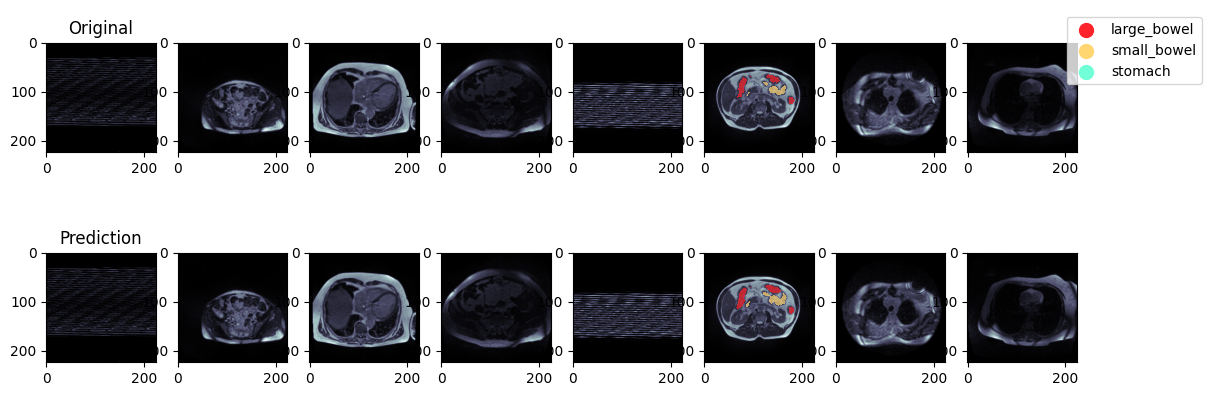

Loss: 0.027877092361450195


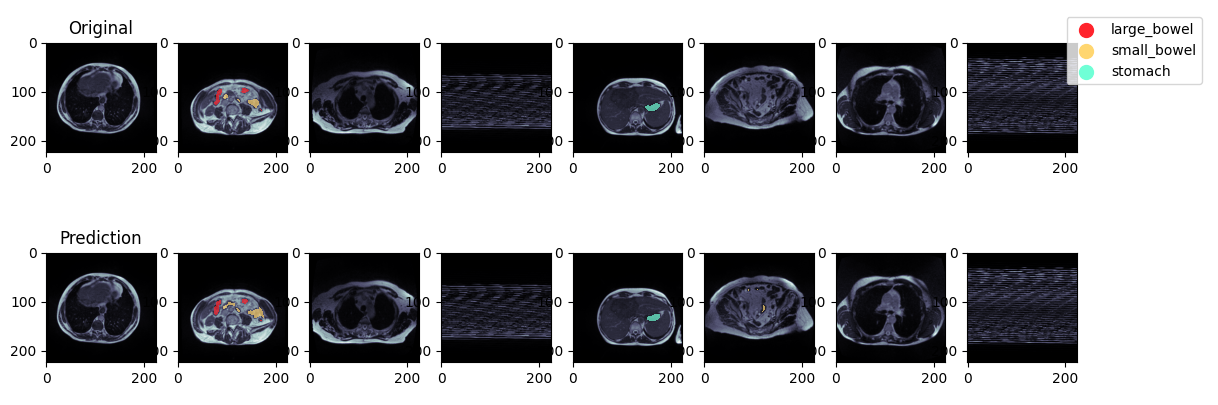

Loss: 0.0850825309753418


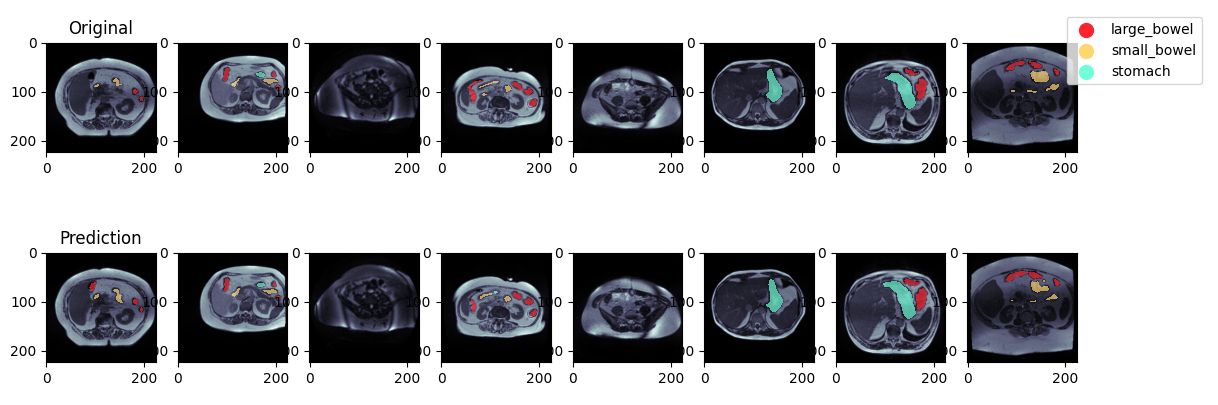

Loss: 0.07063168287277222


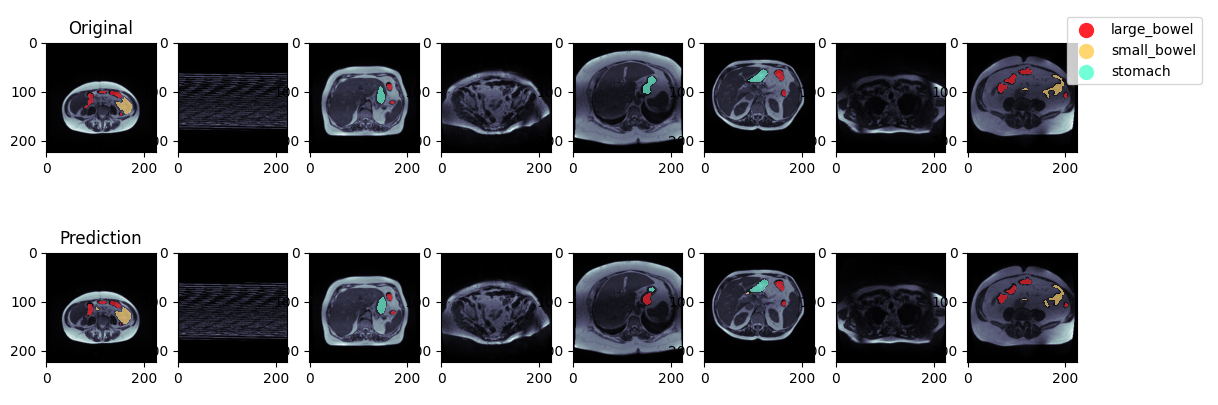

Loss: 0.11453825235366821


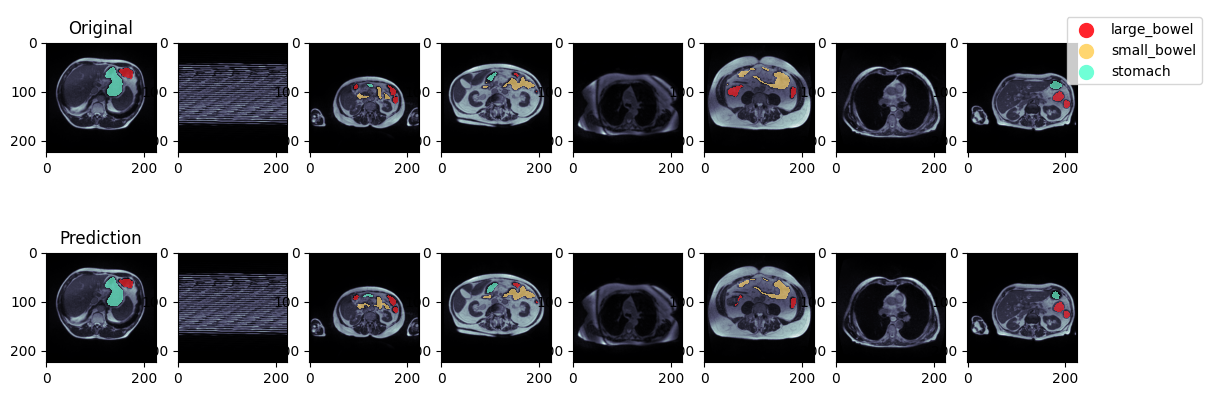

Validation Loss:0.0621369369328022


In [21]:
device = ['cuda:0' if torch.cuda.is_available() else 'cpu']
model = Unet(1,4).to(device[0])
model.eval()
model.load_state_dict(torch.load('/kaggle/input/epoch9/pytorch/default/1/Unet_CE_SGD_no_weights/model_epoch_9'))
loss_fn1 = torch.nn.CrossEntropyLoss()   #BCELosscustom()#torch.nn.BCEWithLogitsLoss()
loss_fn2 = DiceLoss()
loss = []
batches_predicted = 0
for batch ,(slices, label) in tqdm(enumerate(val_loader), total = len(val_loader)):
    if batch %100==0:
        #break
        pred =model(slices.float().to(device[0]))
        loss_metric = loss_fn2(torch.sigmoid(label_to_channels(pred)).cpu(), label.float())
        print(f'Loss: {loss_metric}')
        plot_results_multilabel(slices.cpu(), label.cpu(),torch.argmax(pred, dim =1).cpu())
        loss.append(loss_metric)
        batches_predicted+=1
print(f'Validation Loss:{sum(loss)/batches_predicted}')

## Submission file creation
Convert binary mask predictions to rle and add to csv file

In [22]:
def binary2rle(predictions):
    lb = ''
    sb = ''
    st = ''
    p = predictions.flatten()
    i=0

    while i < p.shape[0]:
        if p[i].item() == 1:
            end_index = 0
            while p[i+end_index].item()==1:
                end_index+=1
                
            lb +=str(i)+' '+str(end_index)+' '
            i += end_index
            
        if p[i].item() == 2:
            end_index = 0
            while p[i+end_index].item()==2:
                end_index+=1
                
            sb +=str(i)+' '+str(end_index)+' '
            i += end_index
            
        if p[i].item() == 3:
            end_index = 0
            while p[i+end_index].item()==3:
                end_index+=1
                
            st +=str(i)+' '+str(end_index)+' '
            i += end_index
        else:
            i+=1
    if lb == '':
        lb += '0'
    else:
        lb =lb[:-1]
    if sb == '':
        sb += '0'
    else:
        sb =sb[:-1]
    if st == '':
        st += '0'
    else:
        st =st[:-1]
    return lb, sb, st
                    
            

In [31]:
submission_csv = pd.DataFrame(columns=['id', 'class', 'predicted'])
submission_data = GI_Tract_Dataset('/kaggle/input/uw-madison-gi-tract-image-segmentation/train', submission_df, transform =None, get_id = True)
submission_loader = torch.utils.data.DataLoader(submission_data, shuffle = False, batch_size =1)


In [32]:
for i, (id, slice, label) in tqdm(enumerate(submission_loader),total = len(submission_loader)):
    pred = model(slice.float().to(device[0]))
    rle = binary2rle(torch.argmax(pred, dim =1))
    submission_csv=pd.concat([submission_csv ,pd.DataFrame({'id':[id[0]], 'class':['large_bowel'], 'predicted':[rle[0]]})])
    submission_csv=pd.concat([submission_csv ,pd.DataFrame({'id':[id[0]], 'class':['small_bowel'], 'predicted':[rle[1]]})])
    submission_csv=pd.concat([submission_csv ,pd.DataFrame({'id':[id[0]], 'class':['stomach'], 'predicted':[rle[2]]})])
    if i ==100:
        break

  0%|          | 0/38496 [00:00<?, ?it/s]

In [61]:
submission_csv.reset_index(inplace=True)
submission_csv.to_csv('submission.csv', index=False)
submission_csv.head()

,id,class,predicted
0,case123_day20_slice_0001,large_bowel,0
1,case123_day20_slice_0001,small_bowel,0
2,case123_day20_slice_0001,stomach,0
3,case123_day20_slice_0002,large_bowel,0
4,case123_day20_slice_0002,small_bowel,0
